<a href="https://colab.research.google.com/github/aaronmj7/MSc_project/blob/main/Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In [ ]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.layers import Attention, GlobalAveragePooling1D, Reshape
from keras.layers import Dropout, Multiply, RepeatVector
from tensorflow.keras.regularizers import l2
from keras.utils import set_random_seed, plot_model
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error


In [ ]:
# Set seaborn theme
sns.set_theme()

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load movies.csv
movies_df = pd.read_csv('/content/drive/MyDrive/ml-32m/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [ ]:
# Load tags.csv
tags_df = pd.read_csv('/content/drive/MyDrive/ml-32m/tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102
...,...,...,...,...
2000067,162279,90645,Rafe Spall,1320817734
2000068,162279,91079,Anton Yelchin,1322337407
2000069,162279,91079,Felicity Jones,1322337400
2000070,162279,91658,Rooney Mara,1325828398


In [ ]:
# Load ratings.csv
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-32m/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [ ]:
# Load links.csv
links_df = pd.read_csv('/content/drive/MyDrive/ml-32m/links.csv')
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


## EDA

In [ ]:
# Display more info

print(movies_df.info(), '\n')
print(tags_df.info(), '\n')
print(ratings_df.info())

In [ ]:
# Check null values
print(movies_df.isnull().sum(), '\n')
print(tags_df.isnull().sum(), '\n')
print(ratings_df.isnull().sum())

In [ ]:
# Get rows with null values
tags_df[tags_df['tag'].isnull()]

In [ ]:
# Drop null values
tags_df.dropna(inplace=True)

In [ ]:
# Check shape
tags_df.shape

In [ ]:
# Describe statistical info
movies_df.describe()

In [ ]:
# Describe statistical info
tags_df.describe()

In [ ]:
# Describe statistical info
ratings_df.describe()

In [ ]:
# Get value count of diferent genres
genre_count = movies_df['genres'].value_counts()
genre_count

In [ ]:
# Get all genres
all_genres = []
for genres in movies_df['genres']:
  all_genres.extend(genres.split('|'))

all_genres = pd.Series(all_genres)
all_genres.value_counts()

In [ ]:
# Get value count of diferent tags
tags_df['tag'].value_counts()

In [ ]:
# Get value count of diferent ratings
rating_count = ratings_df['rating'].value_counts().sort_index()
rating_count

In [ ]:
# Plot rating count
rating_count.plot(kind='bar')
plt.title('Rating Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
# Plot pie chart of rating count
rating_count.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rating Count')
plt.ylabel('')
plt.show()

In [ ]:
# Plot rating boxplot
ratings_df.boxplot(column='rating')
plt.title('Rating Boxplot')
plt.show()

## Data Pre-processing

In [ ]:
# Calculate the average rating for each movie
average_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Set movieId as index
average_ratings_df.set_index('movieId', inplace=True)

# Display average ratings
average_ratings_df

,rating
movieId,
1,3.897438
2,3.275758
3,3.139447
4,2.845331
5,3.059602
...,...
292731,4.000000
292737,1.500000
292753,4.000000


In [ ]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.005082
std,0.801820
min,0.500000
25%,2.543478
50%,3.071429
75%,3.500000
max,5.000000


In [ ]:
# Round the average ratings to the nearest 0.5
average_ratings_df['rating'] = (average_ratings_df['rating'] * 2).round() / 2

average_ratings_df

,rating
movieId,
1,4.0
2,3.5
3,3.0
4,3.0
5,3.0
...,...
292731,4.0
292737,1.5
292753,4.0


In [ ]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.004968
std,0.811505
min,0.500000
25%,2.500000
50%,3.000000
75%,3.500000
max,5.000000


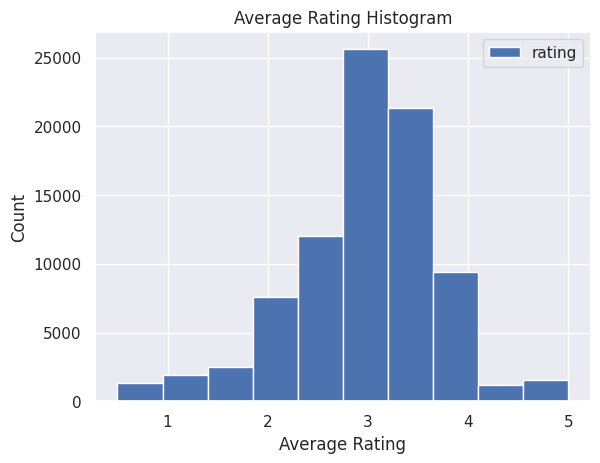

In [ ]:
# Plot
average_ratings_df.plot(kind='hist', bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Average Rating Histogram')
plt.show()

In [ ]:
movie_tag_counts = tags_df.groupby('movieId').size().reset_index(name='tag_count')

movie_tag_counts.set_index('movieId', inplace=True)

movie_tag_counts

,tag_count
movieId,
1,1230
2,573
3,23
4,12
5,64
...,...
292143,12
292349,1
292371,1


In [ ]:
movie_tag_counts.describe()

,tag_count
count,51323.000000
mean,38.970286
std,160.935483
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,6697.000000


In [ ]:
movie_tag_counts.median()

,0
tag_count,5.0


Text(0.5, 1.0, 'Tag Count Boxplot')

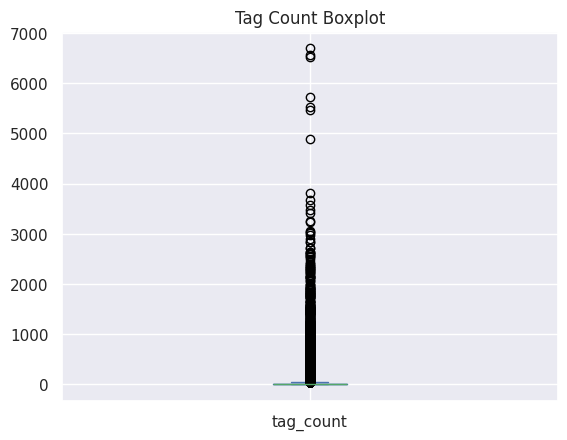

In [ ]:
movie_tag_counts.plot(kind='box')
plt.title('Tag Count Boxplot')

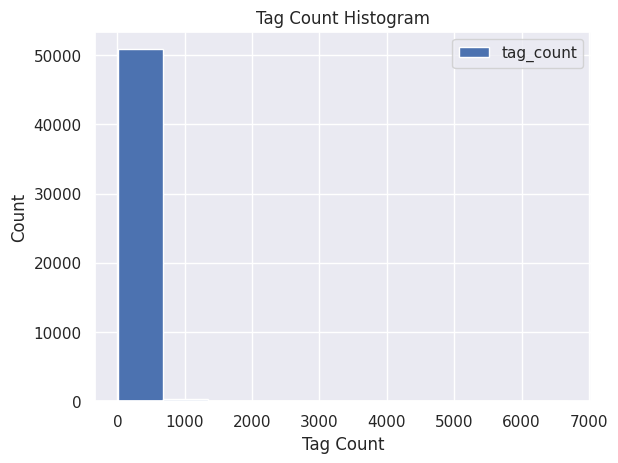

In [ ]:
movie_tag_counts.plot(kind='hist', bins=10)
plt.xlabel('Tag Count')
plt.ylabel('Count')
plt.title('Tag Count Histogram')
plt.show()

In [ ]:
# Count the occurrences of each tag for each movie
tag_counts_df = tags_df.groupby(['movieId', 'tag']).size().reset_index(name='tag_count')

tag_counts_df

,movieId,tag,tag_count
0,1,1990s,1
1,1,2009 reissue in Stereoscopic 3-D,1
2,1,3 dimensional,1
3,1,3D,3
4,1,3d,1
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [ ]:
tag_counts_df.sort_values(by=['movieId', 'tag_count'], ascending=[True, False])

,movieId,tag,tag_count
27,1,Pixar,86
50,1,animation,74
19,1,Disney,54
206,1,funny,50
31,1,Tom Hanks,47
...,...,...,...
1086820,292349,politically incorrect,1
1086821,292371,Stephen King,1
1086822,292597,artificial intelligence,1
1086823,292629,documentary filmmaking,1


In [ ]:
tag_counts_df['tag_count'].describe()

,tag_count
count,1.086825e+06
mean,1.840273e+00
std,5.233296e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,5.960000e+02


In [ ]:
# Take the top n tags for each movie
n = 5
top_tags_df = tag_counts_df.groupby('movieId').head(n)

# Aggregate top tags into a single string for each movie
top_tags_df = top_tags_df.groupby('movieId')['tag'].apply(lambda tags: ', '.join(tags)).reset_index()
top_tags_df.columns = ['movieId', 'top_tags']

# Merge the top tags with average_ratings_df
movies_with_ratings_and_tags_df = pd.merge(average_ratings_df, top_tags_df, on='movieId', how='left')

movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim..."
1,2,3.5,"1860s, 1960s, 1990s, 19th century, 20th century"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon, Minnesota, ..."
3,4,3.0,"CLV, based on novel or book, characters, chick..."
4,5,3.0,"4th wall, CLV, Comedy, Diane Keaton, Fantasy"
...,...,...,...
84427,292731,4.0,NaN
84428,292737,1.5,NaN
84429,292753,4.0,NaN
84430,292755,1.0,NaN


In [ ]:
movies_with_ratings_and_tags_df.dropna(inplace=True)
movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim..."
1,2,3.5,"1860s, 1960s, 1990s, 19th century, 20th century"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon, Minnesota, ..."
3,4,3.0,"CLV, based on novel or book, characters, chick..."
4,5,3.0,"4th wall, CLV, Comedy, Diane Keaton, Fantasy"
...,...,...,...
84360,292057,2.0,illegal immigration
84368,292143,2.5,"Cadaqués, China, Spain, Xiamen, catalonia"
84379,292349,3.0,politically incorrect
84389,292371,2.5,Stephen King


In [ ]:
# Replace '|' with ', ' in the 'genre' column
movies_df['genres'] = movies_df['genres'].str.replace('|', ', ')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy"
1,2,Jumanji (1995),"Adventure, Children, Fantasy"
2,3,Grumpier Old Men (1995),"Comedy, Romance"
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy, Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [ ]:
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy"
1,2,Jumanji (1995),"Adventure, Children, Fantasy"
2,3,Grumpier Old Men (1995),"Comedy, Romance"
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy, Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [ ]:
# Calculate the number of genres for each movie
movies_df['genre_count'] = movies_df['genres'].apply(lambda x: len(x.split(', ')))
movies_df

<ipython-input-25-2b454a0eed16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genre_count'] = movies_df['genres'].apply(lambda x: len(x.split(', ')))


,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [ ]:
movies_df['genre_count'].describe()

,genre_count
count,80505.000000
mean,1.827091
std,0.955556
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,10.000000


In [ ]:
movies_df[movies_df['genre_count'] > 5]['genres']

,genres
196,"Action, Crime, Drama, Mystery, Sci-Fi, Thriller"
359,"Adventure, Animation, Children, Drama, Musical..."
454,"Action, Adventure, Crime, Drama, Romance, Thri..."
540,"Action, Adventure, Children, Comedy, Fantasy, ..."
587,"Animation, Children, Fantasy, Musical, Romance..."
...,...
84413,"Adventure, Animation, Children, Comedy, Fantas..."
85543,"Adventure, Animation, Children, Comedy, Fantas..."
85621,"Action, Adventure, Drama, Fantasy, Mystery, Ro..."
86395,"Action, Adventure, Drama, Horror, Mystery, Thr..."


In [ ]:
movies_df = movies_df[movies_df['genre_count'] <= 5]
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",5
1,2,Jumanji (1995),"Adventure, Children, Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy, Romance",2
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy, Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [ ]:
# Merge movies_with_ratings_and_tags_df with genres from movies_df
final_df = pd.merge(movies_with_ratings_and_tags_df, movies_df[['movieId', 'genres']], on='movieId', how='left')
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim...","Adventure, Animation, Children, Comedy, Fantasy"
1,2,3.5,"1860s, 1960s, 1990s, 19th century, 20th century","Adventure, Children, Fantasy"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon, Minnesota, ...","Comedy, Romance"
3,4,3.0,"CLV, based on novel or book, characters, chick...","Comedy, Drama, Romance"
4,5,3.0,"4th wall, CLV, Comedy, Diane Keaton, Fantasy",Comedy
...,...,...,...,...
48165,292057,2.0,illegal immigration,Drama
48166,292143,2.5,"Cadaqués, China, Spain, Xiamen, catalonia",NaN
48167,292349,3.0,politically incorrect,"Comedy, Horror"
48168,292371,2.5,Stephen King,"Fantasy, Horror"


In [ ]:
final_df.dropna(inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim...","Adventure, Animation, Children, Comedy, Fantasy"
1,2,3.5,"1860s, 1960s, 1990s, 19th century, 20th century","Adventure, Children, Fantasy"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon, Minnesota, ...","Comedy, Romance"
3,4,3.0,"CLV, based on novel or book, characters, chick...","Comedy, Drama, Romance"
4,5,3.0,"4th wall, CLV, Comedy, Diane Keaton, Fantasy",Comedy
...,...,...,...,...
48164,292033,3.0,neighbor,"Comedy, Drama"
48165,292057,2.0,illegal immigration,Drama
48167,292349,3.0,politically incorrect,"Comedy, Horror"
48168,292371,2.5,Stephen King,"Fantasy, Horror"


In [ ]:
final_df.sort_values(by='movieId', inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s, 2009 reissue in Stereoscopic 3-D, 3 dim...","Adventure, Animation, Children, Comedy, Fantasy"
1,2,3.5,"1860s, 1960s, 1990s, 19th century, 20th century","Adventure, Children, Fantasy"
2,3,3.0,"CLV, Funniest Movies, Jack Lemmon, Minnesota, ...","Comedy, Romance"
3,4,3.0,"CLV, based on novel or book, characters, chick...","Comedy, Drama, Romance"
4,5,3.0,"4th wall, CLV, Comedy, Diane Keaton, Fantasy",Comedy
...,...,...,...,...
45886,292033,3.0,neighbor,"Comedy, Drama"
45887,292057,2.0,illegal immigration,Drama
45888,292349,3.0,politically incorrect,"Comedy, Horror"
45889,292371,2.5,Stephen King,"Fantasy, Horror"


In [ ]:
final_df['rating'].describe()

,rating
count,45891.000000
mean,3.074317
std,0.661412
min,0.500000
25%,3.000000
50%,3.000000
75%,3.500000
max,5.000000


In [ ]:
final_df['rating'].value_counts().sort_index()

,count
rating,
0.5,266
1.0,456
1.5,860
2.0,3166
2.5,6705
3.0,15035
3.5,14073
4.0,4757
4.5,287


In [ ]:
pip install gensim

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []

# Prepare data for Word2Vec
tag_sentences = final_df['top_tags'].apply(clean_and_split).tolist()
genre_sentences = final_df['genres'].apply(clean_and_split).tolist()

# Combine all sentences for Word2Vec training
all_sentences = tag_sentences + genre_sentences

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1, seed=42)

# Save vocabulary
tag_vocab = word2vec_model.wv.key_to_index
genre_vocab = word2vec_model.wv.key_to_index

print("\nSample of Word2Vec vocabulary (tags and genres combined):")
print(list(tag_vocab.keys())[:10])

# Function to embed sequences using Word2Vec
def embed_sequence(sequence, model, vector_size=100):
    """
    Embed a sequence of words using Word2Vec model.
    If a word is not in the vocabulary, ignore it.
    """
    embeddings = [model.wv[word] for word in sequence if word in model.wv]
    if len(embeddings) == 0:
        # Return a zero vector if no words are in the vocabulary
        return np.zeros(vector_size)
    return np.mean(embeddings, axis=0)  # Use mean of embeddings for fixed-length representation

X_tags = np.array([embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['top_tags']])
X_genres = np.array([embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['genres']])

print("\nSample tag embeddings:")
print(X_tags[:3])

print("\nSample genre embeddings:")
print(X_genres[:3])



Sample of Word2Vec vocabulary (tags and genres combined):
['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Documentary', 'Crime', 'BD-R', 'Adventure']

Sample tag embeddings:
[[-6.05372004e-02  1.88972317e-02 -3.45052183e-01 -1.04773834e-01
  -1.17990173e-01  2.11932100e-02 -4.08840030e-01  3.66543859e-01
  -7.58587003e-01  1.72550768e-01 -3.08003664e-01  2.24743873e-01
   2.94952959e-01 -4.16303873e-01  2.31519073e-01 -2.50107616e-01
   3.21883634e-02 -3.42459619e-01 -3.05330515e-01 -2.74034701e-02
  -2.93096453e-01  2.98895948e-02 -1.02379881e-01  1.40979871e-01
  -1.45243004e-01  1.27512679e-01 -2.98300236e-01  2.02245563e-02
  -2.06908554e-01  2.77760208e-01 -8.32594186e-02  3.72230679e-01
   6.41857553e-03 -9.22014117e-02  1.10990383e-01 -5.95251620e-01
   1.27091587e-01 -2.48859361e-01  3.36705267e-01  4.16837260e-02
  -4.04837042e-01 -4.46629912e-01  2.11427882e-01 -4.84781086e-01
   2.24582866e-01 -8.12347829e-02  1.44916534e-01 -6.26280624e-03
  -1.93674847e-01

tokenizer

In [ ]:
'''# Initialise tokenizers
tokenizer_tags = Tokenizer(filters='', lower=True)
tokenizer_genres = Tokenizer(filters='', lower=True)

# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []

# Fit tokenizers on cleaned text
tokenizer_tags.fit_on_texts(final_df['top_tags'].apply(clean_and_split))
tokenizer_genres.fit_on_texts(final_df['genres'].apply(clean_and_split))

# Convert to sequences
tag_sequences = tokenizer_tags.texts_to_sequences(final_df['top_tags'].apply(clean_and_split))
genre_sequences = tokenizer_genres.texts_to_sequences(final_df['genres'].apply(clean_and_split))

# Verify tokenization
print("\nSample of genre vocabulary:")
print({v: k for k, v in tokenizer_genres.word_index.items()})
print("\nSample of tag vocabulary:")
print({v: k for k, v in tokenizer_tags.word_index.items()})'''

'# Initialise tokenizers\ntokenizer_tags = Tokenizer(filters=\'\', lower=True)\ntokenizer_genres = Tokenizer(filters=\'\', lower=True)\n\n# Function to clean and split comma-separated items\ndef clean_and_split(x):\n    if isinstance(x, list):\n        # Join list items and split by comma\n        return [item.strip() for item in \',\'.join(x).split(\',\')]\n    elif isinstance(x, str):\n        # Split string by comma\n        return [item.strip() for item in x.split(\',\')]\n    return []\n\n# Fit tokenizers on cleaned text\ntokenizer_tags.fit_on_texts(final_df[\'top_tags\'].apply(clean_and_split))\ntokenizer_genres.fit_on_texts(final_df[\'genres\'].apply(clean_and_split))\n\n# Convert to sequences\ntag_sequences = tokenizer_tags.texts_to_sequences(final_df[\'top_tags\'].apply(clean_and_split))\ngenre_sequences = tokenizer_genres.texts_to_sequences(final_df[\'genres\'].apply(clean_and_split))\n\n# Verify tokenization\nprint("\nSample of genre vocabulary:")\nprint({v: k for k, v in to

In [ ]:
'''# Find the maximum length of sequences for tags and genres
max_tag_length = max(len(seq) for seq in tag_sequences)
max_genre_length = max(len(seq) for seq in genre_sequences)

# Pad sequences
tag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')
genre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')

max_tag_length, max_genre_length'''

"# Find the maximum length of sequences for tags and genres\nmax_tag_length = max(len(seq) for seq in tag_sequences)\nmax_genre_length = max(len(seq) for seq in genre_sequences)\n\n# Pad sequences\ntag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')\ngenre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')\n\nmax_tag_length, max_genre_length"

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Prepare inputs and outputs
X_movie_id = final_df.index.values.reshape(-1, 1)  # Reshape for compatibility with oversampling
# X_tags = tag_sequences_padded
# X_genres = genre_sequences_padded
y = final_df['rating'].values

# Discretize into bins for oversampling
bins = len(np.unique(y))
binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.reshape(-1, 1)).astype(int).flatten()

# Combine features into a single array for oversampling
X_combined = np.hstack([
    X_movie_id,
    X_tags,
    X_genres
])

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_combined, y_binned)

# Split resampled data back into original inputs
X_movie_id_resampled = X_resampled[:, 0].astype(int)
X_tags_resampled = X_resampled[:, 1:X_tags.shape[1] + 1]
X_genres_resampled = X_resampled[:, X_tags.shape[1] + 1:]

# Check y values
np.unique(y_resampled)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Split to train and validation datasets
X_movie_id_train, X_movie_id_val, X_tags_train, X_tags_val, X_genres_train, X_genres_val, y_train, y_val = train_test_split(
    X_movie_id_resampled,
    X_tags_resampled,
    X_genres_resampled,
    y_resampled,
    test_size=0.2,
    random_state=73
)

In [ ]:
# Print data shapes to confirm
print("Training data shapes:")
print("Movie IDs:", X_movie_id_train.shape)
print("Tags:", X_tags_train.shape)
print("Genres:", X_genres_train.shape)
print("Ratings:", y_train.shape)

print("\nValidation data shapes:")
print("Movie IDs:", X_movie_id_val.shape)
print("Tags:", X_tags_val.shape)
print("Genres:", X_genres_val.shape)
print("Ratings:", y_val.shape)

Training data shapes:
Movie IDs: (120280,)
Tags: (120280, 100)
Genres: (120280, 100)
Ratings: (120280,)

Validation data shapes:
Movie IDs: (30070,)
Tags: (30070, 100)
Genres: (30070, 100)
Ratings: (30070,)


## Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, GlobalAveragePooling1D, Flatten, RepeatVector, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np

# Parameters
regularization_strength = 1e-4
dropout_unit = 0.2

# Define the model inputs
movie_input = Input(shape=(1,), name='movie_input')  # For movie IDs
genre_input = Input(shape=(X_genres.shape[1],), name='genre_input')  # Word2Vec genres embeddings
tag_input = Input(shape=(X_tags.shape[1],), name='tag_input')  # Word2Vec tags embeddings

# Embedding Layer for movieId
movie_embedding_layer = Embedding(
    input_dim=len(final_df['movieId'].unique()),
    output_dim=8,
    name='movie_embedding',
    embeddings_regularizer=l2(regularization_strength)
)

# Embed movieId
movie_embeddings = movie_embedding_layer(movie_input)
movie_embeddings = Flatten()(movie_embeddings)  # Flatten for interaction


# Repeat movie embedding to match the dimensions of genres and tags
# Flatten the repeated movie embeddings to align shapes
movie_embedding_repeated_genres = RepeatVector(X_genres.shape[1])(movie_embeddings)
movie_embedding_repeated_tags = RepeatVector(X_tags.shape[1])(movie_embeddings)

# Flatten the repeated embeddings to align with the genre_input and tag_input shape
movie_embedding_repeated_genres = Flatten()(movie_embedding_repeated_genres)
movie_embedding_repeated_tags = Flatten()(movie_embedding_repeated_tags)

# Concatenate embeddings for interaction
movie_genre_embeddings = Concatenate()([genre_input, movie_embedding_repeated_genres])
movie_tag_embeddings = Concatenate()([tag_input, movie_embedding_repeated_tags])


# Reshape to 3D tensor before pooling
movie_genre_embeddings_reshaped = Reshape((-1, 1))(movie_genre_embeddings)
movie_tag_embeddings_reshaped = Reshape((-1, 1))(movie_tag_embeddings)


# Deep Component
# Attention layer
genre_attention = Attention(name="genre_attention")([movie_genre_embeddings_reshaped, movie_genre_embeddings_reshaped])
tag_attention = Attention(name="tag_attention")([movie_tag_embeddings_reshaped, movie_tag_embeddings_reshaped])

# Concatenation layer
deep_interaction_layer = Concatenate()([
    GlobalAveragePooling1D()(genre_attention),
    GlobalAveragePooling1D()(tag_attention)
])


# Dense layers with L2 regularization and dropout
deep_dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength), name='deep_dense_layer_1')(deep_interaction_layer)
deep_dense_layer = Dropout(dropout_unit)(deep_dense_layer)

# Wide Component
# Global Average Pooling to create fixed-length vectors for wide component
genre_pooled_wide = GlobalAveragePooling1D()(movie_genre_embeddings_reshaped)
tag_pooled_wide = GlobalAveragePooling1D()(movie_tag_embeddings_reshaped)

# Element-wise product for low-order interactions in the wide component
wide_interaction_layer = Multiply()([genre_pooled_wide, tag_pooled_wide])

# Combine Deep and Wide Components
combined_layer = Concatenate()([deep_dense_layer, wide_interaction_layer])

# Final Dense Layer with L2 regularization and dropout
final_dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(regularization_strength), name='final_dense_layer_1')(combined_layer)
final_dense_layer = Dropout(dropout_unit)(final_dense_layer)

# Output Layer for regression
output = Dense(1, activation='linear', name='output_layer')(final_dense_layer)

# Define model
model = Model(inputs=[movie_input, genre_input, tag_input], outputs=output, name='FastText_Enhanced_Model')

model.summary()


Model: "FastText_Enhanced_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 8)           │        367,128 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8)              │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 100, 8)         │              0 │ flatten[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 100, 8)         │              0 │ flatten[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_input (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 800)            │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_input (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 800)            │              0 │ repeat_vector_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 900)            │              0 │ genre_input[0][0],     │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 900)            │              0 │ tag_input[0][0],       │
│ (Concatenate)             │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 900, 1)         │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 900, 1)         │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_attention           │ (None, 900, 1)         │              0 │ reshape[0][0],         │
│ (Attention)               │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_attention (Attention) │ (None, 900, 1)         │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 1)              │              0 │ genre_attention[0][0]  │
│ (GlobalAveragePooling

 Total params: 369,465 (1.41 MB)

 Trainable params: 369,465 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

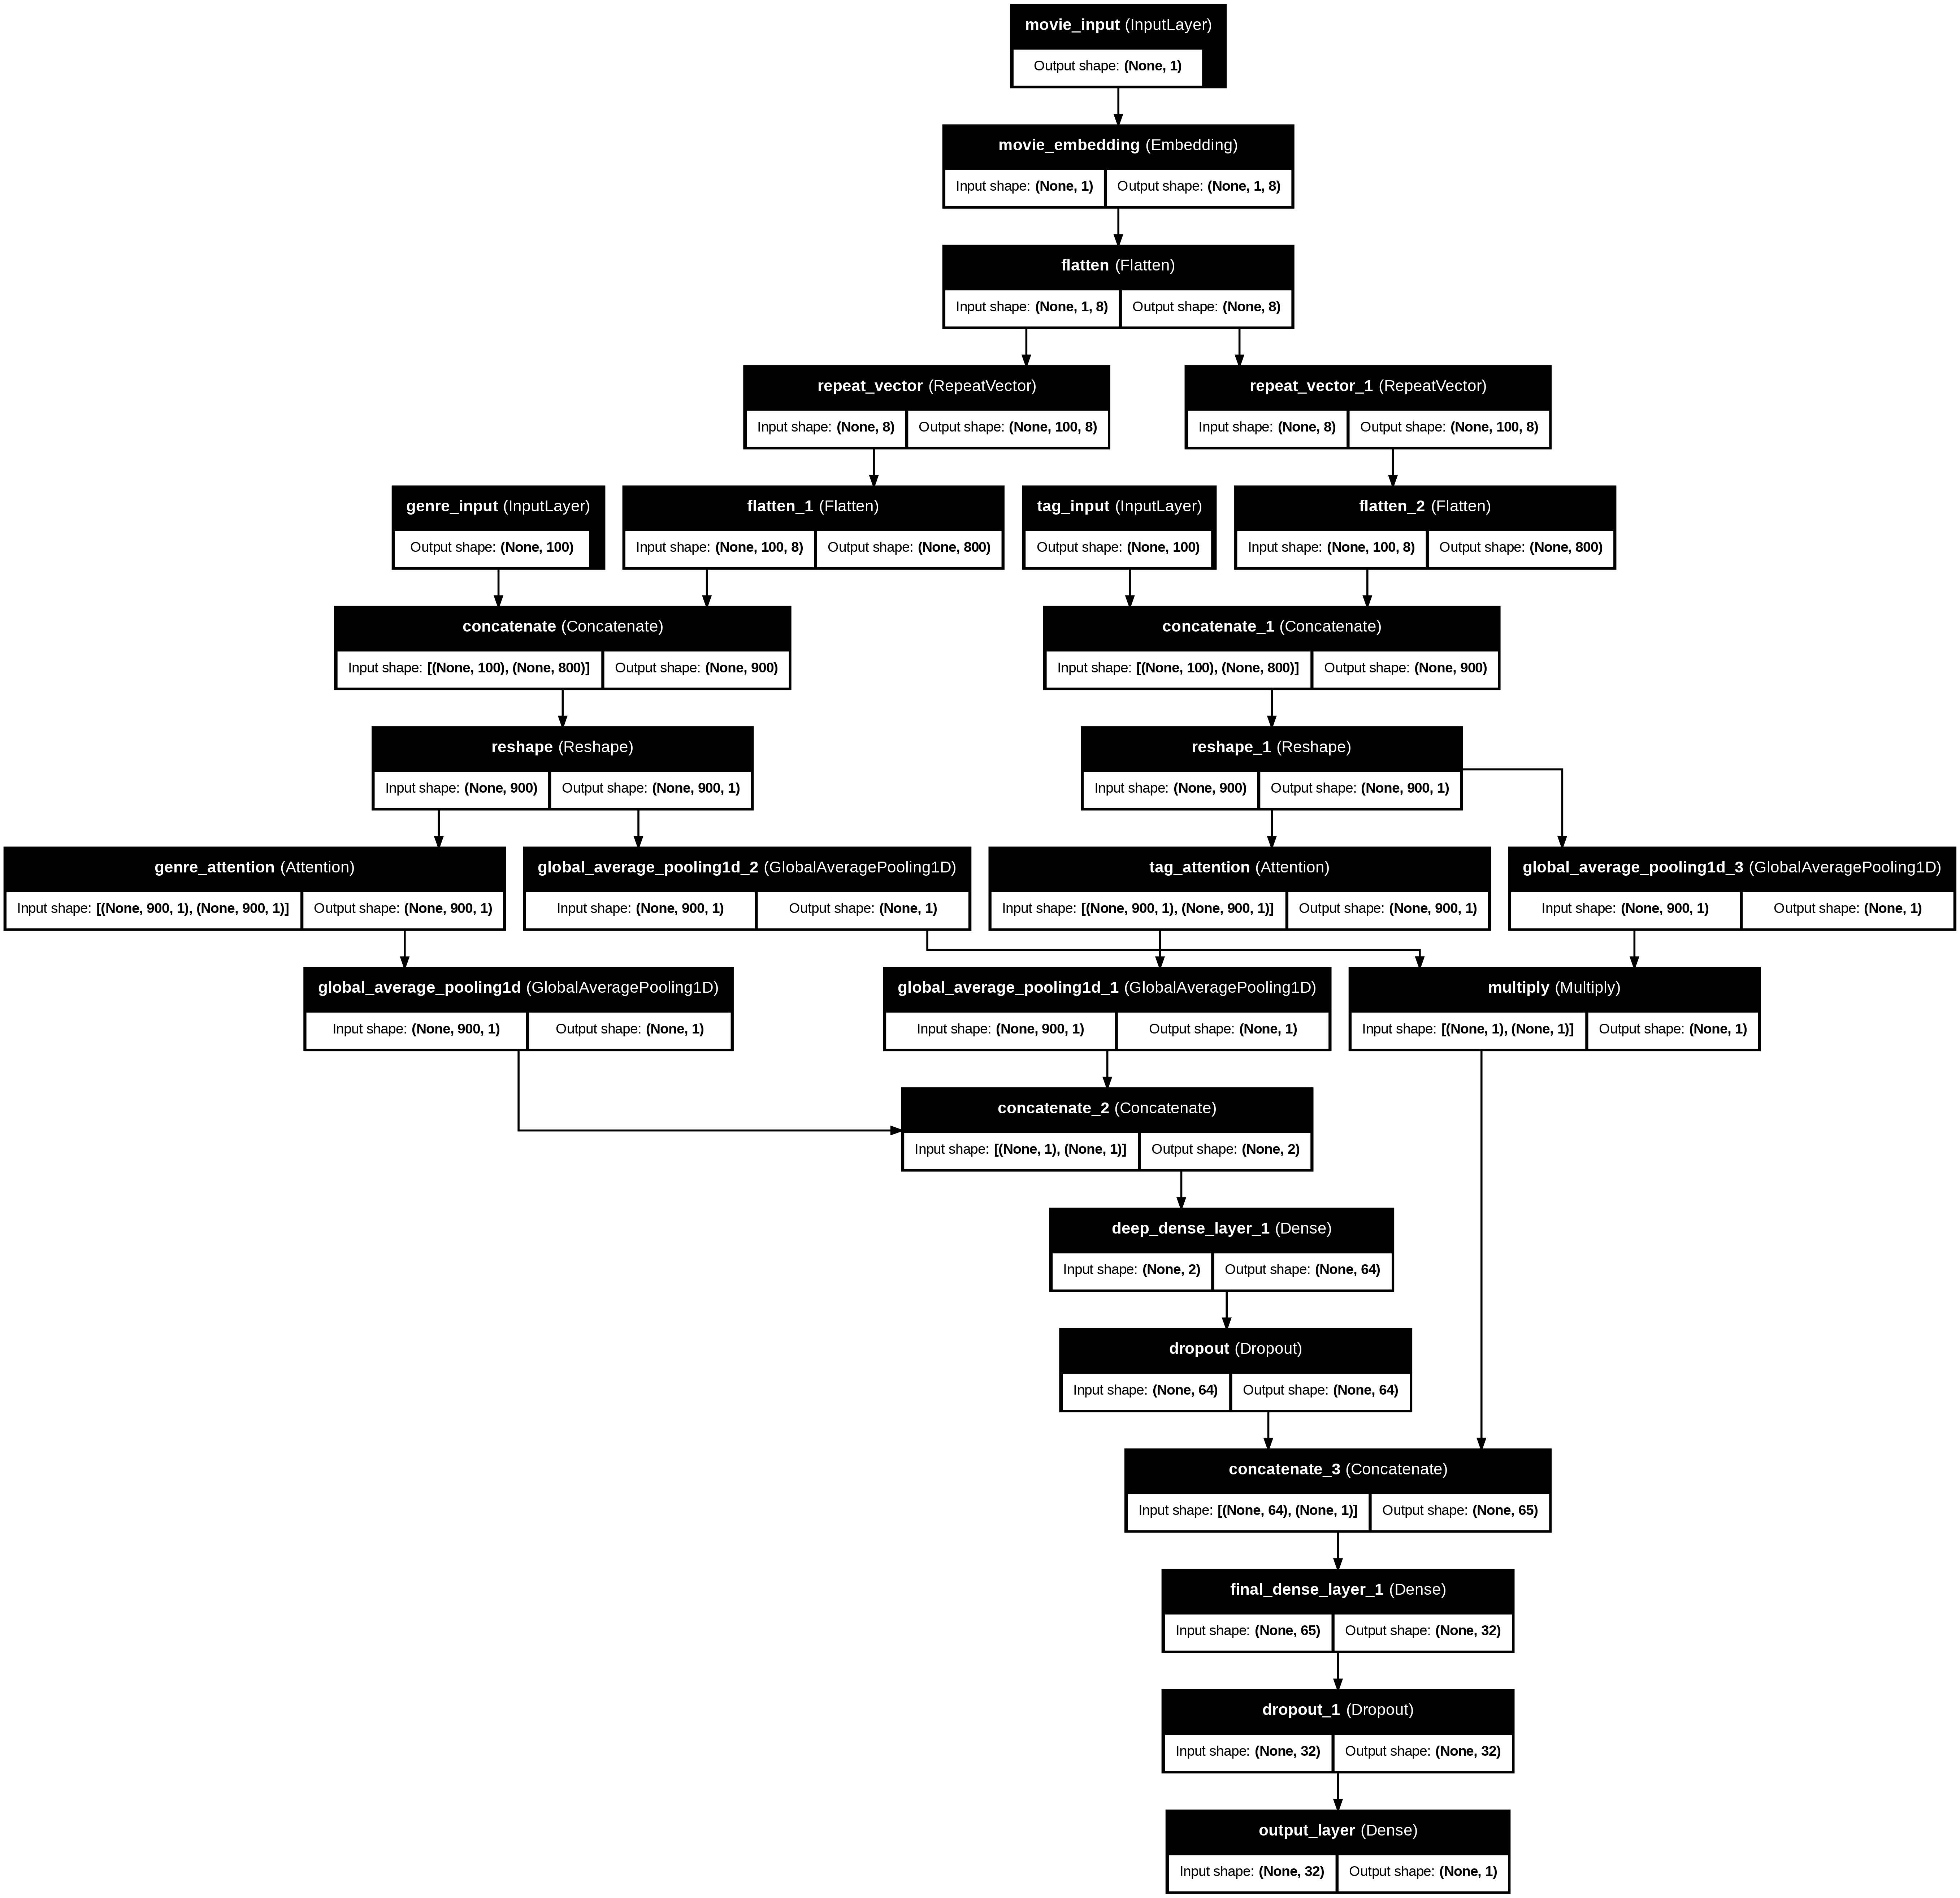

In [ ]:
# Plot model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 128

X_train = [X_movie_id_train, X_genres_train, X_tags_train]
X_val = [X_movie_id_val, X_genres_val, X_tags_val]

history = model.fit(
    X_train,y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 23.9681 - mean_absolute_error: 4.0518 - val_loss: 7.6394 - val_mean_absolute_error: 2.3932
Epoch 2/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 6.6831 - mean_absolute_error: 2.2462 - val_loss: 2.6734 - val_mean_absolute_error: 1.4924
Epoch 3/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 2.3692 - mean_absolute_error: 1.2742 - val_loss: 0.8744 - val_mean_absolute_error: 0.7312
Epoch 4/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 1.1921 - mean_absolute_error: 0.8442 - val_loss: 0.5533 - val_mean_absolute_error: 0.5329
Epoch 5/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.8489 - mean_absolute_error: 0.6937 - val_loss: 0.4116 - val_mean_absolute_error: 0.4223
Epoch 6/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.6854 - mean_absolute_error: 0.6019 - val_loss: 0.3704 - val_mean_absolute_error: 0.3729
Epoch 7/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.6083 - mean_absolute_er

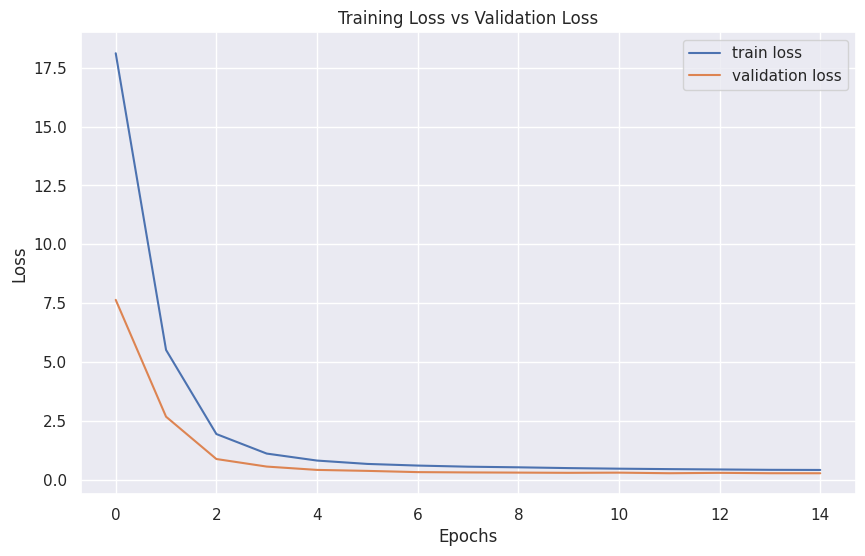

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

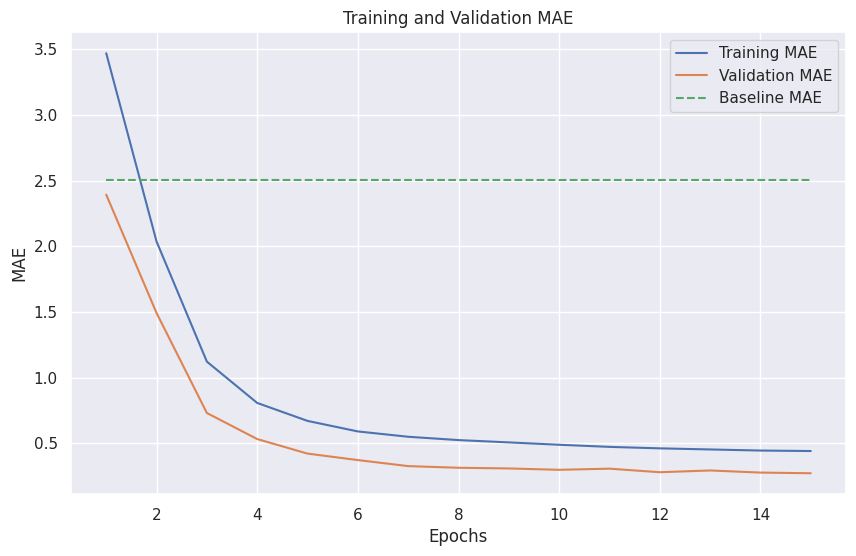

In [ ]:
# Extract MAE values
training_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
baseline_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
baseline_mae_list = [baseline_mae] * len(training_mae)  # Create a list of the baseline MAE

epochs = range(1, len(training_mae) + 1)

# Plot the MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.plot(epochs, baseline_mae_list, ls='--', label='Baseline MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/ml-32m/model.keras')

In [ ]:
'''# Evaluate the model
val_loss, val_mae = model.evaluate([X_movie_id_val, X_genres_val, X_tags_val], y_val, verbose=1)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Mean Absolute Error: {val_mae:.4f}")
'''

'# Evaluate the model\nval_loss, val_mae = model.evaluate([X_movie_id_val, X_genres_val, X_tags_val], y_val, verbose=1)\nprint(f"Val Loss: {val_loss:.4f}")\nprint(f"Val Mean Absolute Error: {val_mae:.4f}")\n'

In [ ]:
# Predict on validation or test data
predictions = model.predict([X_movie_id_val, X_genres_val, X_tags_val])

# Reshape predictions if necessary (depending on output layer)
predictions = predictions.flatten()

# Example of displaying some predictions
for i in range(5):
    print(f"Actual Rating: {y_val[i]:.1f}, Predicted Rating: {predictions[i]:.2f}")


940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Actual Rating: 1.0, Predicted Rating: 1.00
Actual Rating: 8.0, Predicted Rating: 7.88
Actual Rating: 2.0, Predicted Rating: 1.89
Actual Rating: 6.0, Predicted Rating: 4.60
Actual Rating: 2.0, Predicted Rating: 1.81


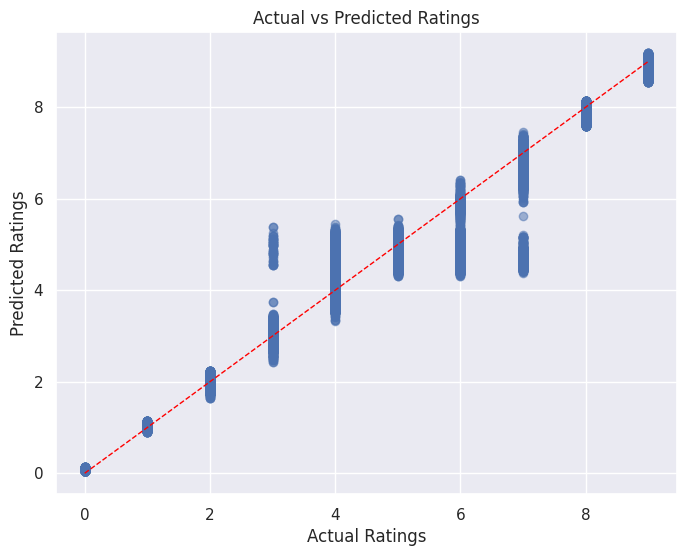

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([0, 9], [0, 9], color='red', linestyle='--', linewidth=1)  # Ideal line
plt.title("Actual vs Predicted Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()

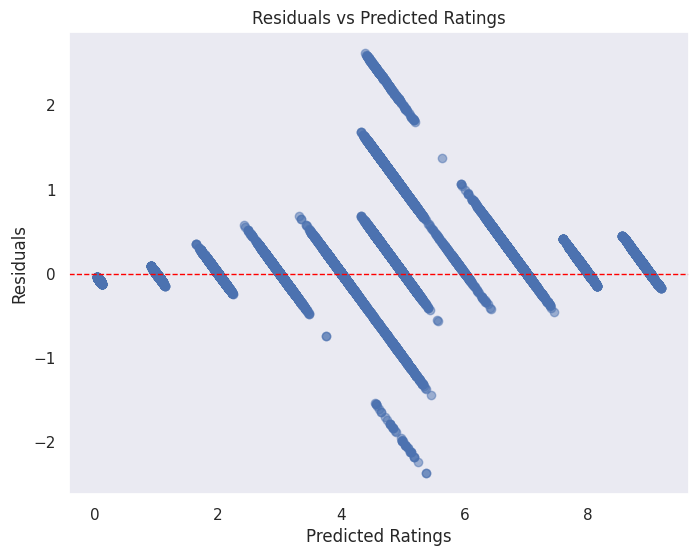

In [ ]:
residuals = y_val - predictions

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted Ratings")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.grid()
plt.show()


## Feature Analysis

In [ ]:
# Load saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ml-32m/model.keras')

In [ ]:
pip install shap

In [ ]:
import numpy as np
import pandas as pd
import shap

def predict_wrapper(X):
    """
    Wrapper function to make model predictions compatible with SHAP
    X is expected to be a 2D numpy array with columns: movie_id, genres, tags
    """
    # Ensure X is properly sliced
    movie_ids = X[:, 0].astype(int)  # Movie IDs
    genres = X[:, 1:X_genres_train.shape[1]+1]  # Extract genre embeddings
    tags = X[:, X_genres_train.shape[1]+1:]  # Extract tag embeddings

    # Return predictions
    return model.predict([movie_ids, genres, tags]).flatten()


# Combine validation data into single array
X_combined = np.hstack([X_movie_id_val.reshape(-1, 1), X_genres_val, X_tags_val])

# Create SHAP explainer using model-agnostic approach
explainer = shap.KernelExplainer(predict_wrapper, X_combined[:50])

# Calculate SHAP values for a sample of validation data
shap_values = explainer.shap_values(X_combined[:100])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3829/3829 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Separate the SHAP values for genres and tags
genre_shap = shap_values[:, 1:X_genres_train.shape[1]+1]
tag_shap = shap_values[:, X_genres_train.shape[1]+1:]

# Debugging: Check the shape of genre_shap and tag_shap
print("Shape of genre_shap:", genre_shap.shape)
print("Shape of tag_shap:", tag_shap.shape)

# Aggregate absolute SHAP values for genres and tags
genre_importance = np.abs(genre_shap).mean(axis=0)
tag_importance = np.abs(tag_shap).mean(axis=0)

# Get unique genre and tag names from original data
unique_genres = list(set([genre for genres in final_df['genres'].apply(clean_and_split) for genre in genres]))
unique_tags = list(set([tag for tags in final_df['top_tags'].apply(clean_and_split) for tag in tags]))

# Debugging: Check the lengths of unique_genres and unique_tags
print("Number of unique genres:", len(unique_genres))
print("Number of unique tags:", len(unique_tags))

# Fix genre_importance length to match unique genres (if needed)
# In this case, the genre_importance has a length of 100 (as we have 100 features), but you only have 19 unique genres.
# So, we need to aggregate or truncate to match.
# Here, I assume you want to map each SHAP value to a genre, so we truncate the genre_importance.

# If the number of genres and the number of features don't match, you can average over the features to match.
# For simplicity, we will assume the first 19 features correspond to the 19 unique genres.
# Aggregate genre_importance to the length of unique genres:
genre_importance = genre_importance[:len(unique_genres)]

# Similarly, ensure tag_importance has the correct length (35189 tags):
tag_importance = tag_importance[:len(unique_tags)]

# Create DataFrames for genre and tag importance
genre_df = pd.DataFrame({
    'genre': unique_genres[:len(genre_importance)],  # Ensure the length matches genre_importance
    'importance': genre_importance
}).sort_values('importance', ascending=False).head(10)

tag_df = pd.DataFrame({
    'tag': unique_tags[:len(tag_importance)],  # Ensure the length matches tag_importance
    'importance': tag_importance
}).sort_values('importance', ascending=False).head(10)

# Return results
results = {'top_genres': genre_df, 'top_tags': tag_df}


Shape of genre_shap: (100, 100)
Shape of tag_shap: (100, 100)
Number of unique genres: 19
Number of unique tags: 35189


In [ ]:
print("Top Influential Genres:")
print(results['top_genres'])
print("\nTop Influential Tags:")
print(results['top_tags'])

Top Influential Genres:
          genre  importance
9        Horror    0.015429
15     Thriller    0.013478
17          War    0.012553
6       Musical    0.012409
10      Fantasy    0.010975
16    Film-Noir    0.010836
5        Comedy    0.007956
8     Animation    0.007750
3   Documentary    0.007516
4       Romance    0.006484

Top Influential Tags:
                                   tag  importance
68                               china    0.006564
90                     highschool kids    0.005691
8                     ernest hemingway    0.005635
79           Ernst-Hugo JÃƒÂ¤regÃƒÂ¥rd    0.005017
6                              obvious    0.004990
27                              U-boat    0.004590
49                    Billie Jean King    0.004544
10                        for children    0.004267
53  Preponing of nuking so predictable    0.004164
40                             avenger    0.004078


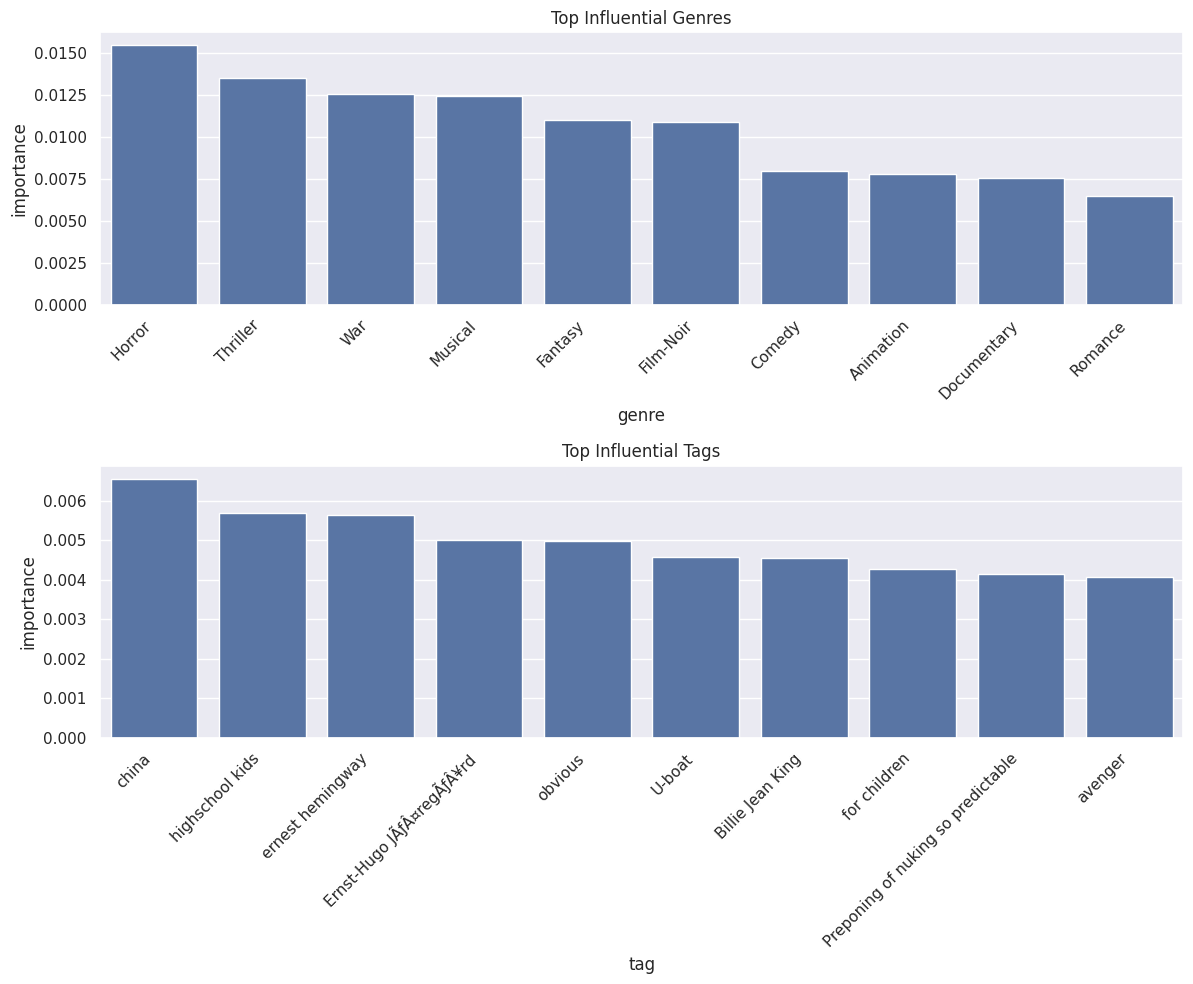

In [ ]:
def visualize_shap_results(results):
    # Set up the plot
    plt.figure(figsize=(12, 10))

    # Genres subplot
    plt.subplot(2, 1, 1)
    sns.barplot(x='genre', y='importance', data=results['top_genres'])
    plt.title('Top Influential Genres')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Tags subplot
    plt.subplot(2, 1, 2)
    sns.barplot(x='tag', y='importance', data=results['top_tags'])
    plt.title('Top Influential Tags')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

# Visualize results
visualize_shap_results(results)